<a href="https://colab.research.google.com/github/someoneinthecrowd/AI-CSTR-report/blob/master/Torus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

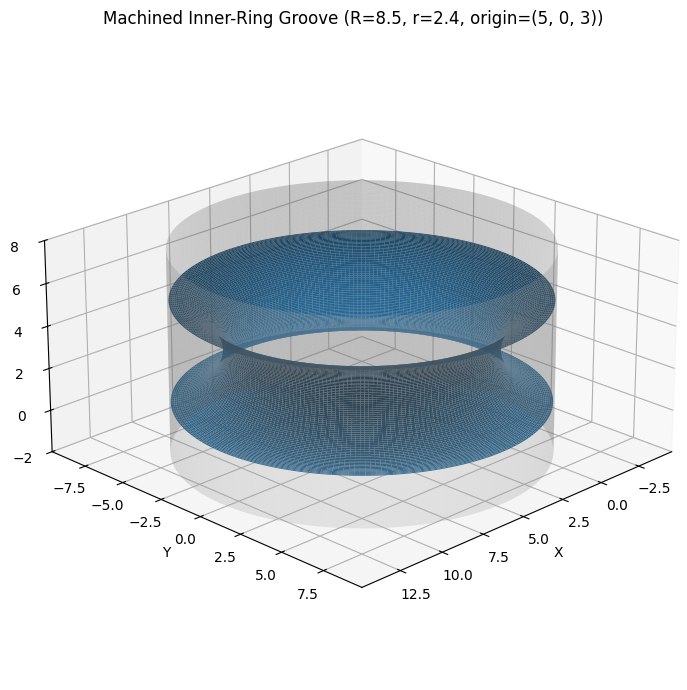

In [34]:
import numpy as np
import matplotlib.pyplot as plt


def set_axes_data_ratio(ax):
    """Set 3D axes box aspect to the *data extents* (keeps real X:Y:Z ratios)."""
    xlim = ax.get_xlim3d(); ylim = ax.get_ylim3d(); zlim = ax.get_zlim3d()
    xr = abs(xlim[1] - xlim[0]); yr = abs(ylim[1] - ylim[0]); zr = abs(zlim[1] - zlim[0])
    if hasattr(ax, "set_box_aspect"):
        ax.set_box_aspect((xr, yr, zr))


def torus_surface(u, v, R, r, x0=0.0, y0=0.0, z0=0.0):
    """Standard torus parameterization with optional origin shift.
    (u = angle around the big circle, v = tube angle).
    (x0, y0, z0) specify the center translation.
    """
    x = (R + r * np.cos(v)) * np.cos(u) + x0
    y = (R + r * np.cos(v)) * np.sin(u) + y0
    z = r * np.sin(v) + z0
    return x, y, z


def cylinder(theta, z_vals, radius, x0=0.0, y0=0.0, z0=0.0):
    """Helper: cylinder aligned with Z axis, centered at (x0,y0)."""
    Theta, Z = np.meshgrid(theta, z_vals, indexing="ij")
    X = radius * np.cos(Theta) + x0
    Y = radius * np.sin(Theta) + y0
    Z = Z + z0
    return X, Y, Z


def plot_inner_ring_groove(
    R=8.5,
    r=2.4,
    ring_half_width=0.4,
    ring_radius=None,
    groove_color="#1f77b4",
    ring_color="#aaaaaa",
    alpha_ring=0.25,
    n_u=220,
    n_v=180,
    n_circ=200,
    n_z=80,
    limit_to_inside=False,
    view_elev=22,
    view_azim=45,
    origin=(0.0, 0.0, 0.0),   # <-- new option
):
    """Plot the *machined groove patch* as if a ball-end mill cut a cylinder.

    Parameters
    ----------
    origin : (x0, y0, z0)
        Center offset for the torus and cylinder.
    """
    if ring_radius is None:
        ring_radius = R

    x0, y0, z0 = origin

    # Parameters for the full torus
    u = np.linspace(0.0, 2 * np.pi, n_u)
    v = np.linspace(-np.pi, np.pi, n_v)
    U, V = np.meshgrid(u, v, indexing="ij")

    Xt, Yt, Zt = torus_surface(U, V, R, r, x0, y0, z0)

    # Machined patch mask
    if limit_to_inside:
        rho = np.sqrt((Xt - x0)**2 + (Yt - y0)**2)
        inside_cyl = rho <= (ring_radius + 1e-12)
    else:
        inside_cyl = np.ones_like(Xt, dtype=bool)

    inside_axial = np.abs(Zt - z0) <= ring_half_width
    mask = inside_cyl & inside_axial

    Xt_mask = np.where(mask, Xt, np.nan)
    Yt_mask = np.where(mask, Yt, np.nan)
    Zt_mask = np.where(mask, Zt, np.nan)

    # Cylinder for context
    theta = np.linspace(0.0, 2 * np.pi, n_circ)
    z_vals = np.linspace(-ring_half_width, ring_half_width, n_z)
    Xc, Yc, Zc = cylinder(theta, z_vals, ring_radius ,x0, y0, z0)

    # Plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        Xt_mask, Yt_mask, Zt_mask, rstride=1, cstride=1,
        linewidth=0, antialiased=True, alpha=1.0, color=groove_color
    )

    # Optional: add cylinder context (transparent)
    ax.plot_surface(
        Xc, Yc, Zc, rstride=1, cstride=1,
        linewidth=0, antialiased=True, alpha=alpha_ring, color=ring_color
    )

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(
        f"Machined Inner-Ring Groove (R={R}, r={r}, origin={origin})"
    )

    ax.view_init(elev=view_elev, azim=view_azim)
    plt.tight_layout()
    set_axes_data_ratio(ax)

    return fig, ax


if __name__ == "__main__":
    # Example with shifted origin
    fig, ax = plot_inner_ring_groove(
        R=8.5, r=2.4, ring_half_width=4.8, ring_radius=8.5,
        limit_to_inside=True, origin=(5, 0, 3)
    )
    plt.show()


# New Section

{'R': 8.500555083128196,
 'r': 2.39879217122393,
 'center': (1.9994028749718848, -0.9995146038426795, 0.4976676365716072),
 'rmse': 0.0014601785298371454}

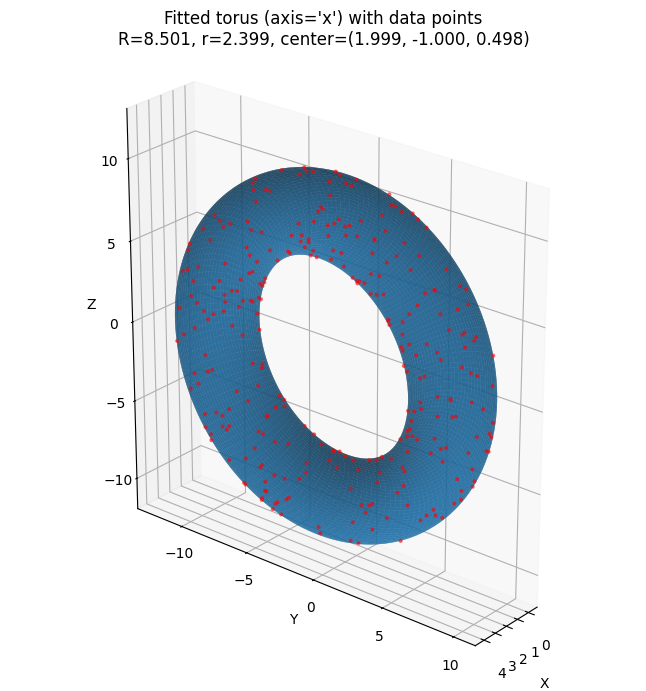

In [40]:
# Plot 3D data points and the fitted torus surface together (axis-selectable).
# This cell generates synthetic data for an X-axis–aligned torus, fits it,
# and plots both the noisy points and the recovered torus surface.

import numpy as np
import matplotlib.pyplot as plt

def set_axes_data_ratio(ax):
    """Set 3D axes box aspect to the *data extents* (keeps real X:Y:Z ratios)."""
    xlim = ax.get_xlim3d(); ylim = ax.get_ylim3d(); zlim = ax.get_zlim3d()
    xr = abs(xlim[1] - xlim[0]); yr = abs(ylim[1] - ylim[0]); zr = abs(zlim[1] - zlim[0])
    if hasattr(ax, "set_box_aspect"):
        ax.set_box_aspect((xr, yr, zr))

def _circle_fit_2d(a, b):
    """Algebraic circle fit to 2D points (a,b). Returns (a0, b0, R)."""
    a = np.asarray(a); b = np.asarray(b)
    am, bm = a.mean(), b.mean()
    A = a - am
    B = b - bm
    Z = A*A + B*B
    D = np.column_stack((A, B, np.ones_like(A)))
    sol, *_ = np.linalg.lstsq(D, Z, rcond=None)
    aa, bb, cc = sol
    a0 = 0.5 * aa + am
    b0 = 0.5 * bb + bm
    R  = np.sqrt((a0 - am)**2 + (b0 - bm)**2 + cc)
    return a0, b0, R

def fit_torus_aligned(points, axis='z', robust=True):
    """
    Fit a torus aligned with a principal axis (axis in {'x','y','z'}).

    Returns dict with R, r, center=(x0,y0,z0), rmse.
    """
    from scipy.optimize import least_squares

    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 3:
        raise ValueError("points must be (N,3)")

    # Permutations to map chosen axis -> work 'z'
    if axis == 'z':
        def map_in(p):  return p
        def map_out(c): return c
    elif axis == 'x':
        # (x,y,z) -> (y,z,x)
        def map_in(p):  return np.column_stack([p[:,1], p[:,2], p[:,0]])
        def map_out(c): return (c[2], c[0], c[1])
    elif axis == 'y':
        # (x,y,z) -> (z,x,y)
        def map_in(p):  return np.column_stack([p[:,2], p[:,0], p[:,1]])
        def map_out(c): return (c[1], c[2], c[0])
    else:
        raise ValueError("axis must be one of {'x','y','z'}")

    W = map_in(P)
    Xw, Yw, Zw = W[:,0], W[:,1], W[:,2]

    # Initial guesses in work frame
    x0g, y0g, Rg = _circle_fit_2d(Xw, Yw)
    z0g = float(Zw.mean())
    rho = np.sqrt((Xw - x0g)**2 + (Yw - y0g)**2)
    rg = np.sqrt(np.mean((rho - Rg)**2 + (Zw - z0g)**2))
    if rg <= 1e-9:
        rg = np.std(rho - Rg) + 1e-6

    p0 = np.array([x0g, y0g, z0g, Rg, rg], dtype=float)

    def residuals(p):
        x0, y0, z0, R, r = p
        dx = Xw - x0
        dy = Yw - y0
        dz = Zw - z0
        q = dx*dx + dy*dy + dz*dz
        rho2 = dx*dx + dy*dy
        F = (q + R*R - r*r)**2 - 4.0*(R*R)*rho2
        scale = (np.abs(q + R*R - r*r) + 1.0)
        return F / (scale * scale)

    lower = [-np.inf, -np.inf, -np.inf, 1e-9, 1e-9]
    upper = [ np.inf,  np.inf,  np.inf, np.inf, np.inf]
    kwargs = {}
    if robust:
        kwargs.update(dict(loss="soft_l1", f_scale=1.0))
    res = least_squares(residuals, p0, bounds=(lower, upper), **kwargs)

    x0w, y0w, z0w, R_hat, r_hat = res.x
    rmse = float(np.sqrt(np.mean(res.fun**2)))
    cx, cy, cz = map_out((float(x0w), float(y0w), float(z0w)))

    return {
        "R": float(R_hat),
        "r": float(r_hat),
        "center": (cx, cy, cz),
        "rmse": rmse,
    }

def _axis_maps(axis):
    """Return (map_in, map_out) for the given axis, consistent with fit_torus_aligned."""
    if axis == 'z':
        def map_in(p):  return p
        def map_out(c): return c
    elif axis == 'x':
        def map_in(p):  return np.column_stack([p[:,1], p[:,2], p[:,0]])
        def map_out(c): return (c[2], c[0], c[1])
    elif axis == 'y':
        def map_in(p):  return np.column_stack([p[:,2], p[:,0], p[:,1]])
        def map_out(c): return (c[1], c[2], c[0])
    else:
        raise ValueError("axis must be one of {'x','y','z'}")
    return map_in, map_out

def plot_points_and_fitted_torus(points, fit_result, axis='z', n_u=120, n_v=60, elev=22, azim=35):
    """
    Plot noisy data points and the fitted torus surface in one 3D figure.

    - points: (N,3) array
    - fit_result: dict from fit_torus_aligned with keys R, r, center
    - axis: 'x', 'y', or 'z' denoting torus symmetry axis
    """
    points = np.asarray(points, dtype=float)
    R = fit_result["R"]
    r = fit_result["r"]
    cx, cy, cz = fit_result["center"]

    # Build a surface in the work frame (axis == 'z'), then map out.
    map_in, map_out = _axis_maps(axis)

    # Convert center to work frame by applying map_in to a single point
    C_orig = np.array([[cx, cy, cz]])
    C_work = map_in(C_orig)[0]
    x0w, y0w, z0w = C_work

    u = np.linspace(0.0, 2*np.pi, n_u)
    v = np.linspace(-np.pi, np.pi, n_v)
    U, V = np.meshgrid(u, v, indexing="ij")
    Xw = (R + r*np.cos(V)) * np.cos(U) + x0w
    Yw = (R + r*np.cos(V)) * np.sin(U) + y0w
    Zw =  r*np.sin(V) + z0w

    # Map the surface back to the original frame
    surf_work = np.column_stack([Xw.ravel(), Yw.ravel(), Zw.ravel()])
    X, Y, Z = np.empty_like(Xw), np.empty_like(Yw), np.empty_like(Zw)
    # map_out expects a tuple; apply to each vertex
    out = np.apply_along_axis(lambda p: np.array(map_out((p[0], p[1], p[2]))), 1, surf_work)
    X[:] = out[:,0].reshape(Xw.shape)
    Y[:] = out[:,1].reshape(Yw.shape)
    Z[:] = out[:,2].reshape(Zw.shape)

    # Plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(points[:,0], points[:,1], points[:,2], s=4, alpha=0.5,c='r')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.7)

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"Fitted torus (axis='{axis}') with data points\nR={R:.3f}, r={r:.3f}, center=({cx:.3f}, {cy:.3f}, {cz:.3f})")

    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    set_axes_data_ratio(ax)
    return fig, ax

# ---------------- Demo: Generate X-axis torus data, fit, and plot ----------------
rng = np.random.default_rng(2)
N = 300
R_true, r_true = 8.5, 2.4
center_true = (2.0, -1.0, 0.5)
axis = 'x'

# Generate in work frame (axis='z') then permute back for axis='x'
u = rng.uniform(0, 2*np.pi, N)
v = rng.uniform(-np.pi, np.pi, N)
# choose work-frame center that maps back to center_true
# For axis='x', map_out(cw) = (cw_z, cw_x, cw_y) = center_true  -> choose cw = (cy, cz, cx)
cw = (center_true[1], center_true[2], center_true[0])
Xw = (R_true + r_true*np.cos(v))*np.cos(u) + cw[0]
Yw = (R_true + r_true*np.cos(v))*np.sin(u) + cw[1]
Zw =  r_true*np.sin(v) + cw[2]
# Map back to original frame for axis='x': (x,y,z) = (Zw, Xw, Yw)
x = Zw
y = Xw
z = Yw
pts = np.column_stack([x, y, z]) + 0.02 * rng.standard_normal((N,3))

fit = fit_torus_aligned(pts, axis=axis, robust=True)
fig, ax = plot_points_and_fitted_torus(pts, fit, axis=axis, n_u=160, n_v=80, elev=25, azim=40)

fit


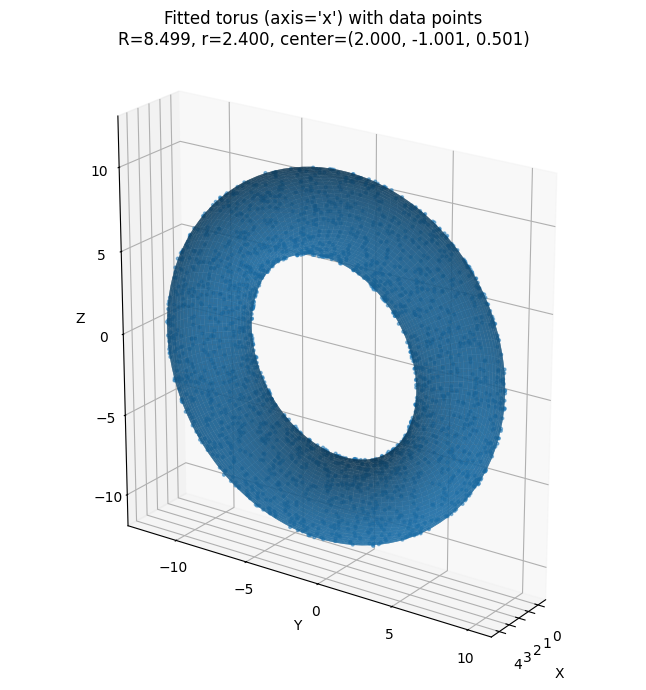

In [38]:
fit = fit_torus_aligned(pts, axis='x', robust=True)
fig, ax = plot_points_and_fitted_torus(pts, fit, axis='x')


({'R': 9.366425194200112,
  'r': 1.5129354296820172,
  'center': (2.357811157193188, -1.0094317215553281, 0.4762256244539134),
  'rmse': 0.001196183486060476},
 0.07197183199775364,
 0.05190095784631275)

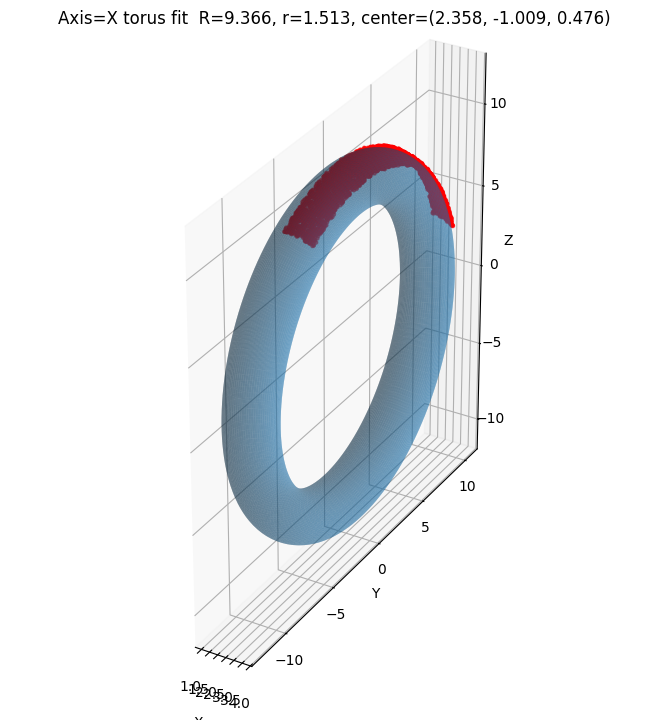

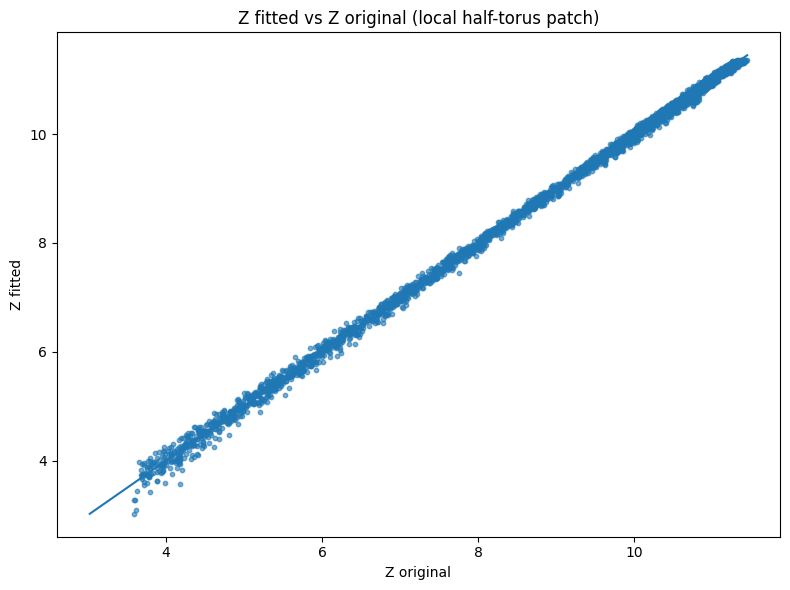

In [103]:
# Single-file demo script: Fit a torus whose symmetry axis is along X ONLY,
# then (for a local half-torus patch) compute z_pred from (x,y) using the fitted
# parameters, and plot (1) 3D points + fitted surface, and (2) Z fitted vs Z original.
#
# Usage inside this cell: it generates synthetic data, fits, and plots.
#
# Requirements: numpy, matplotlib, scipy

import numpy as np
import matplotlib.pyplot as plt


# ---------- Core math (X-axis torus) ----------

def fit_torus_axis_x(points, robust=True):
    """
    Fit a torus with axis along X to 3D points (N,3).
    Implicit model:
        ((dx^2 + dy^2 + dz^2) + R^2 - r^2)^2 - 4 R^2 (dy^2 + dz^2) = 0
    where d* are coordinates relative to the center (cx,cy,cz).
    Returns dict: {"R","r","center","rmse"}.
    """
    from scipy.optimize import least_squares

    P = np.asarray(points, dtype=float)
    if P.ndim != 2 or P.shape[1] != 3:
        raise ValueError("points must be (N,3)")

    x, y, z = P[:,0], P[:,1], P[:,2]

    # ---- Initial guesses ----
    # Center on X: cx ~ mean(x)
    cx0 = float(x.mean())
    # In YZ plane, fit circle (y,z) to seed (cy,cz,R)
    cy0, cz0, R0 = _circle_fit_2d(y, z)
    # r from local tube distance
    dy = y - cy0; dz = z - cz0; dx = x - cx0
    rho = np.sqrt(dy*dy + dz*dz)
    r0 = float(np.sqrt(np.mean((rho - R0)**2 + dx*dx)))
    if r0 <= 1e-9:
        r0 = float(np.std(rho - R0) + 1e-6)

    p0 = np.array([cx0, cy0, cz0, R0, r0], dtype=float)

    # ---- Residuals (implicit) ----
    def residuals(p):
        cx, cy, cz, R, r = p
        dx = x - cx; dy = y - cy; dz = z - cz
        q = dx*dx + dy*dy + dz*dz
        rho2 = dy*dy + dz*dz
        F = (q + R*R - r*r)**2 - 4.0*R*R*rho2
        scale = (np.abs(q + R*R - r*r) + 1.0)
        return F / (scale*scale)

    bounds = ([-np.inf, -np.inf, -np.inf, 1e-9, 1e-9],
              [ np.inf,  np.inf,  np.inf, np.inf, np.inf])
    kwargs = {}
    if robust:
        kwargs.update(dict(loss="soft_l1", f_scale=1.0))

    res = least_squares(residuals, p0, bounds=bounds, **kwargs)
    cx, cy, cz, R, r = res.x
    rmse = float(np.sqrt(np.mean(res.fun**2)))
    return {"R": float(R), "r": float(r), "center": (float(cx), float(cy), float(cz)), "rmse": rmse}


def predict_z_from_xy_axis_x(points, fit_result):
    """
    Given points (N,3) from a *local half-torus patch* (so z(x,y) is single-valued),
    compute z_pred from the fitted torus parameters.
    For axis=X, the cross-section relation is:
        (rho - R)^2 + dx^2 = r^2,   rho = sqrt((y-cy)^2 + (z-cz)^2)
    Solve for rho and then z. Choose branch closest to the measured z.
    Returns z_pred (N,).
    """
    P = np.asarray(points, dtype=float)
    x, y, z_meas = P[:,0], P[:,1], P[:,2]
    cx, cy, cz = fit_result["center"]
    R, r = fit_result["R"], fit_result["r"]

    dx = x - cx
    # First, solve for rho = R ± sqrt(r^2 - dx^2) (clip inside due to noise)
    inside = np.maximum(r*r - dx*dx, 0.0)
    rho_plus  = R + np.sqrt(inside)
    rho_minus = R - np.sqrt(inside)

    # For each rho candidate, compute z candidates given y:
    # z = cz ± sqrt(rho^2 - (y-cy)^2), clipped non-negative inside sqrt
    yy = (y - cy)**2
    zcand = []
    for rho in (rho_plus, rho_minus):
        inside2 = np.maximum(rho*rho - yy, 0.0)
        root = np.sqrt(inside2)
        zcand.append(cz + root)
        zcand.append(cz - root)
    # shape -> (4, N)
    ZC = np.vstack(zcand)
    # pick closest to measured z
    idx = np.argmin(np.abs(ZC - z_meas), axis=0)
    z_pred = ZC[idx, np.arange(len(z_meas))]
    return z_pred


def _circle_fit_2d(a, b):
    """Algebraic circle fit to 2D points (a,b). Returns (a0, b0, R)."""
    a = np.asarray(a); b = np.asarray(b)
    am, bm = a.mean(), b.mean()
    A = a - am
    B = b - bm
    Z = A*A + B*B
    D = np.column_stack((A, B, np.ones_like(A)))
    sol, *_ = np.linalg.lstsq(D, Z, rcond=None)
    aa, bb, cc = sol
    a0 = 0.5 * aa + am
    b0 = 0.5 * bb + bm
    R  = np.sqrt((a0 - am)**2 + (b0 - bm)**2 + cc)
    return a0, b0, R


def torus_surface_axis_x(center, R, r, n_u=140, n_v=80):
    """Generate a torus surface (axis=X) for plotting."""
    cx, cy, cz = center
    u = np.linspace(0.0, 2*np.pi, n_u)
    v = np.linspace(-np.pi, np.pi, n_v)
    U, V = np.meshgrid(u, v, indexing="ij")
    X = r*np.sin(V) + cx
    Y = (R + r*np.cos(V))*np.cos(U) + cy
    Z = (R + r*np.cos(V))*np.sin(U) + cz
    return X, Y, Z


# ---------- Demo (local half-torus patch) ----------

def demo_local_half_patch_and_plots():
    rng = np.random.default_rng(42)

    # Ground truth (axis=X)
    R_true, r_true = 8.5, 2.4
    center_true = (2.0, -1.0, 0.5)

    # Generate a local patch so z(x,y) is single-valued
    u0, v0 = 1.2, 0.4
    du, dv = 0.9, 0.35         # keep dv small to stay single-valued
    Nu, Nv = 60, 70
    u = rng.uniform(u0 - du, u0 + du, Nu*Nv)
    v = rng.uniform(v0 - dv, v0 + dv, Nu*Nv)

    X = r_true*np.sin(v) + center_true[0]
    Y = (R_true + r_true*np.cos(v))*np.cos(u) + center_true[1]
    Z = (R_true + r_true*np.cos(v))*np.sin(u) + center_true[2]

    pts_clean = np.column_stack([X, Y, Z])

    # Add noise
    sigma = 0.03
    pts = pts_clean + sigma * rng.standard_normal(pts_clean.shape)

    # Fit
    fit = fit_torus_axis_x(pts, robust=True)

    # Predict z from (x,y) using fitted params (single-valued region)
    z_pred = predict_z_from_xy_axis_x(pts, fit)

    # --- Plot 1: 3D points + fitted surface ---
    Xs, Ys, Zs = torus_surface_axis_x(fit["center"], fit["R"], fit["r"], n_u=160, n_v=80)
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=6, alpha=0.6,c='r')
    ax.plot_surface(Xs, Ys, Zs, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.4)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(f"Axis=X torus fit  R={fit['R']:.3f}, r={fit['r']:.3f}, center={tuple(round(c,3) for c in fit['center'])}")
    # Keep a reasonable aspect visually
    xlim = ax.get_xlim3d(); ylim = ax.get_ylim3d(); zlim = ax.get_zlim3d()
    ax.set_box_aspect((abs(xlim[1]-xlim[0]), abs(ylim[1]-ylim[0]), abs(zlim[1]-zlim[0])))
    plt.tight_layout()

    # --- Plot 2: Z fitted vs Z original ---
    fig2 = plt.figure(figsize=(8,6))
    ax2 = fig2.add_subplot(111)
    ax2.scatter(pts[:,2], z_pred, s=10, alpha=0.6)
    m = min(pts[:,2].min(), z_pred.min())
    M = max(pts[:,2].max(), z_pred.max())
    ax2.plot([m, M], [m, M])
    ax2.set_xlabel("Z original")
    ax2.set_ylabel("Z fitted")
    ax2.set_title("Z fitted vs Z original (local half-torus patch)")
    plt.tight_layout()

    # Basic residual stats
    rmse = float(np.sqrt(np.mean((z_pred - pts[:,2])**2)))
    mae  = float(np.mean(np.abs(z_pred - pts[:,2])))
    return fit, rmse, mae,pts,z_pred

# Run the demo
fit, rmse, mae ,pts,z_pred= demo_local_half_patch_and_plots()
fit, rmse, mae


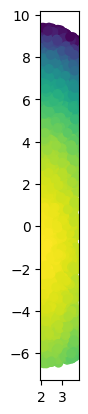

In [107]:
fig, ax = plt.subplots()
plt.scatter(pts[:,0],pts[:,1],c=pts[:,2])
ax.set_aspect('equal')

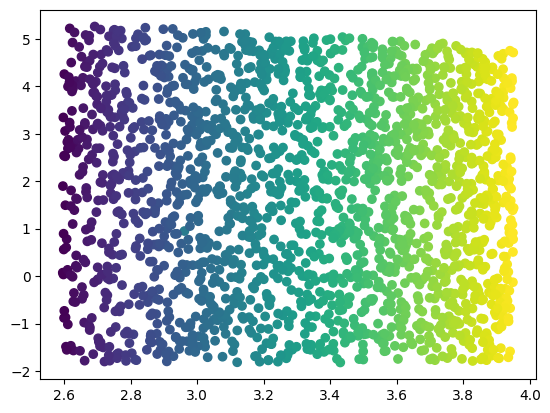

In [98]:
plt.scatter(pts[:,0],pts[:,1],c=z_pred)

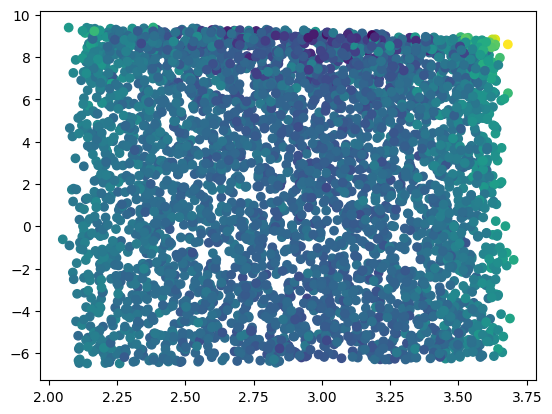

In [108]:
plt.scatter(pts[:,0],pts[:,1],c=pts[:,2]-z_pred)

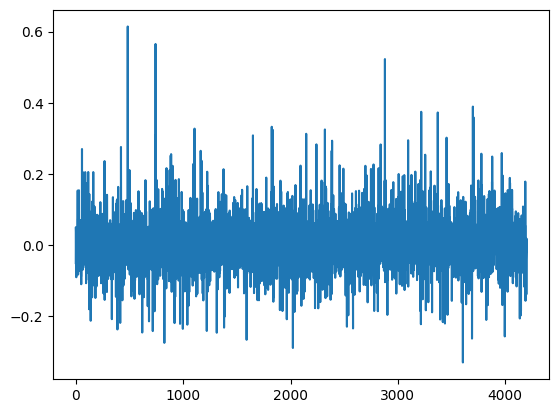

In [109]:
plt.plot(pts[:,2]-z_pred)

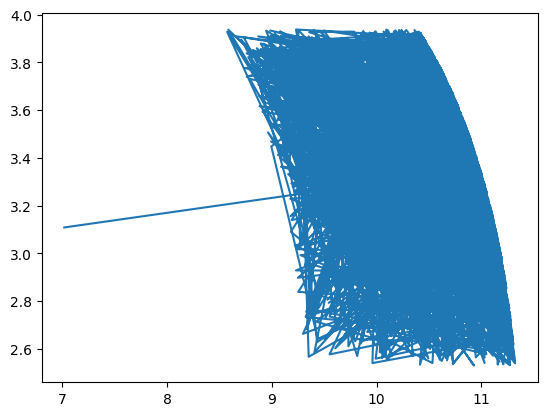

In [102]:
plt.plot(pts[:,2], z_pred)